In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import warnings
from mlfinpy import labeling, util
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully")

Libraries imported successfully


In [3]:
# Import the data
eurusd = pd.read_csv(r"../DATA/4-hours Pepperstone/4-hours_EURUSD.csv", parse_dates=True, index_col="time")
print(f"EURUSD data shape: {eurusd.shape}")
print(f"Date range: {eurusd.index[0]} to {eurusd.index[-1]}")
eurusd.head()

EURUSD data shape: (13676, 7)
Date range: 2015-01-02 12:00:00 to 2023-09-20 08:00:00


,open,high,low,close,tick_volume,low_time,high_time
time,,,,,,,
2015-01-02 12:00:00,1.20467,1.20600,1.20347,1.20377,14827,2015-01-02 15:36:00,2015-01-02 12:48:00
2015-01-02 16:00:00,1.20377,1.20437,1.20069,1.20131,19160,2015-01-02 19:36:00,2015-01-02 16:00:00
2015-01-02 20:00:00,1.20133,1.20154,1.20011,1.20029,9335,2015-01-02 23:12:00,2015-01-02 20:00:00
2015-01-03 00:00:00,1.20030,1.20055,1.19997,1.20014,1351,2015-01-03 00:24:00,2015-01-03 00:00:00
2015-01-05 00:00:00,1.19454,1.19755,1.18642,1.19624,13941,2015-01-05 00:48:00,2015-01-05 03:36:00


In [4]:
def generate_ma_crossover_signals(df, fast_period=20, slow_period=50):
    """
    Generate MA crossover signals
    """
    df = df.copy()
    
    # Calculate moving averages
    df['ma_fast'] = df['close'].rolling(window=fast_period).mean()
    df['ma_slow'] = df['close'].rolling(window=slow_period).mean()
    
    # Generate signals
    df['signal'] = 0
    df.loc[df['ma_fast'] > df['ma_slow'], 'signal'] = 1  # Bullish
    df.loc[df['ma_fast'] < df['ma_slow'], 'signal'] = -1  # Bearish
    
    # Detect crossovers (entry points)
    df['signal_shift'] = df['signal'].shift(1)
    df['entry_long'] = ((df['signal'] == 1) & (df['signal_shift'] != 1)).astype(int)
    df['entry_short'] = ((df['signal'] == -1) & (df['signal_shift'] != -1)).astype(int)
    df['entry_signal'] = df['entry_long'] - df['entry_short']  # 1 for long, -1 for short, 0 for none
    
    return df

eurusd = generate_ma_crossover_signals(eurusd, fast_period=20, slow_period=50)

# Count signals
long_signals = (eurusd['entry_signal'] == 1).sum()
short_signals = (eurusd['entry_signal'] == -1).sum()
print(f"Long entry signals: {long_signals}")
print(f"Short entry signals: {short_signals}")
print(f"Total entry signals: {long_signals + short_signals}")

eurusd.tail()

Long entry signals: 163
Short entry signals: 164
Total entry signals: 327


,open,high,low,close,tick_volume,low_time,high_time,ma_fast,ma_slow,signal,signal_shift,entry_long,entry_short,entry_signal
time,,,,,,,,,,,,,,
2023-09-19 16:00:00,1.06997,1.07014,1.06785,1.06848,13607,2023-09-19 19:36:00,2023-09-19 16:00:00,1.067004,1.070427,-1,-1.0,0,0,0
2023-09-19 20:00:00,1.06848,1.06918,1.06761,1.06790,6544,2023-09-19 22:00:00,2023-09-19 20:24:00,1.067015,1.070398,-1,-1.0,0,0,0
2023-09-20 00:00:00,1.06790,1.06860,1.06768,1.06849,2478,2023-09-20 00:00:00,2023-09-20 03:36:00,1.067197,1.070360,-1,-1.0,0,0,0
2023-09-20 04:00:00,1.06849,1.06897,1.06783,1.06786,4333,2023-09-20 06:24:00,2023-09-20 05:12:00,1.067370,1.070326,-1,-1.0,0,0,0
2023-09-20 08:00:00,1.06786,1.06972,1.06730,1.06964,11014,2023-09-20 08:48:00,2023-09-20 11:36:00,1.067640,1.070291,-1,-1.0,0,0,0


In [ ]:
volatility = util.get_daily_vol(eurusd['close'], lookback = 60)  # Use 'Close'

In [27]:
volatility

time
2015-01-05 00:00:00         NaN
2015-01-05 04:00:00    0.001290
2015-01-05 08:00:00    0.000909
2015-01-05 12:00:00    0.002434
2015-01-05 16:00:00    0.002199
                         ...   
2023-09-19 16:00:00    0.003635
2023-09-19 20:00:00    0.003485
2023-09-20 00:00:00    0.003322
2023-09-20 04:00:00    0.003172
2023-09-20 08:00:00    0.003057
Name: close, Length: 13672, dtype: float64

In [20]:
tpsl=[1, 1]  

# Filter to only actual entry signals (not zeros)
entry_signals_only = eurusd['entry_signal'][eurusd['entry_signal'] != 0]
print(f"Total entry signals: {len(entry_signals_only)}")
print(f"  Long signals: {(entry_signals_only == 1).sum()}")
print(f"  Short signals: {(entry_signals_only == -1).sum()}")

vertical_barrier = labeling.add_vertical_barrier(
    eurusd.index, 
    eurusd['close'],
    num_days = 20  # expiration limit
)
print(f"✓ Vertical barriers created: {len(vertical_barrier)} timestamps")

# Get the 3B events - only for actual entry signals
triple_barrier_events = labeling.get_events(
    close=eurusd['close'],
    t_events=entry_signals_only.index,  # Only timestamps with actual signals
    pt_sl=tpsl,
    target=volatility,
    min_ret=0.0,
    num_threads=4,
    vertical_barrier_times=vertical_barrier,
    side_prediction=entry_signals_only  # Matching sides for these events
)

print(f"\n✓ Triple barrier events generated: {len(triple_barrier_events)}")
print(f"  Events DataFrame shape: {triple_barrier_events.shape}")
print(f"  Columns: {triple_barrier_events.columns.tolist()}")

# Get bins (meta-labels: 1 = correct prediction, 0 = wrong prediction)
labels = labeling.get_bins(triple_barrier_events, eurusd['close'])

print(f"\n✓ Labels generated:")
print(f"  Labels shape: {labels.shape}")
print(f"  Bin value counts:")
print(labels['bin'].value_counts())
print(f"  Bin 1 (correct): {(labels['bin'] == 1).sum()} ({(labels['bin'] == 1).sum() / len(labels) * 100:.1f}%)")
print(f"  Bin 0 (incorrect): {(labels['bin'] == 0).sum()} ({(labels['bin'] == 0).sum() / len(labels) * 100:.1f}%)")


Total entry signals: 327
  Long signals: 163
  Short signals: 164
✓ Vertical barriers created: 13592 timestamps


2025-11-05 16:36:37.066375 100.0% triple_barriers done after 0.03 minutes. Remaining 0.0 minutes.



✓ Triple barrier events generated: 327
  Events DataFrame shape: (327, 5)
  Columns: ['t1', 'trgt', 'side', 'pt', 'sl']

✓ Labels generated:
  Labels shape: (327, 4)
  Bin value counts:
bin
0    166
1    161
Name: count, dtype: int64
  Bin 1 (correct): 161 (49.2%)
  Bin 0 (incorrect): 166 (50.8%)


In [23]:
def create_bin_heatmap(df, labels_df, sigma=2.0):
    """
    Create heatmap from meta-labeling bins.
    
    Bin = 1 (correct prediction) → Positive heatmap peak
    Bin = 0 (incorrect prediction) → Negative heatmap peak
    
    Parameters:
    -----------
    df : DataFrame with time index (full price data)
    labels_df : Labels DataFrame from get_bins() with index and 'bin' column
    sigma : Standard deviation of Gaussian in bars
    
    Returns:
    --------
    df with new columns:
    - bin_heatmap: Gaussian heatmap centered on bin events [-1, +1]
    - bin_label: Binary meta-labels aligned with price data [0, 1]
    """
    df = df.copy()
    
    # Initialize arrays
    positive_binary = np.zeros(len(df), dtype=np.float32)
    negative_binary = np.zeros(len(df), dtype=np.float32)
    bin_labels = np.zeros(len(df), dtype=np.float32)
    
    # Mark events at their index positions
    for timestamp, row in labels_df.iterrows():
        if timestamp in df.index:
            idx = df.index.get_loc(timestamp)
            bin_value = row['bin']
            
            # Store the actual bin value
            bin_labels[idx] = bin_value
            
            # Create binary markers for heatmap
            if bin_value == 1:
                positive_binary[idx] = 1.0  # Correct prediction
            else:
                negative_binary[idx] = 1.0  # Incorrect prediction
    
    # Build Gaussian kernel
    radius = int(np.ceil(3 * sigma))
    x = np.arange(-radius, radius + 1, dtype=np.float32)
    kernel = np.exp(-0.5 * (x / sigma) ** 2)
    kernel = kernel / kernel.max()  # Normalize to [0, 1]
    
    # Convolve to create smooth heatmaps
    positive_heatmap = np.convolve(positive_binary, kernel, mode='same')
    negative_heatmap = np.convolve(negative_binary, kernel, mode='same')
    
    # Combine: positive bins get positive values, negative bins get negative values
    bin_heatmap = positive_heatmap - negative_heatmap
    
    # Clip to [-1, 1]
    bin_heatmap = np.clip(bin_heatmap, -1.0, 1.0)
    
    # Add to dataframe
    df['bin_heatmap'] = bin_heatmap
    df['bin_label'] = bin_labels
    df['positive_heatmap'] = positive_heatmap  # For visualization
    df['negative_heatmap'] = -negative_heatmap  # For visualization
    
    print("\nBin Heatmap Statistics:")
    print(f"  Heatmap range: [{bin_heatmap.min():.4f}, {bin_heatmap.max():.4f}]")
    print(f"  Positive peaks (bin=1): {(positive_binary == 1).sum()}")
    print(f"  Negative peaks (bin=0): {(negative_binary == 1).sum()}")
    print(f"  Total labeled events: {(bin_labels > 0).sum()}")
    
    return df

# Create heatmap from bins
eurusd = create_bin_heatmap(eurusd, labels, sigma=2.0)

print("\nDataFrame columns:")
print(eurusd[['bin_heatmap', 'bin_label', 'positive_heatmap', 'negative_heatmap']].describe())



Bin Heatmap Statistics:
  Heatmap range: [-1.0000, 1.0000]
  Positive peaks (bin=1): 161
  Negative peaks (bin=0): 166
  Total labeled events: 161

DataFrame columns:
       bin_heatmap     bin_label  positive_heatmap  negative_heatmap
count  13676.00000  13676.000000      13676.000000      13676.000000
mean      -0.00157      0.011772          0.058958         -0.060789
std        0.28232      0.107864          0.198479          0.201867
min       -1.00000      0.000000          0.000000         -1.764994
25%        0.00000      0.000000          0.000000         -0.000000
50%        0.00000      0.000000          0.000000         -0.000000
75%        0.00000      0.000000          0.000000          0.000000
max        1.00000      1.000000          1.764994         -0.000000


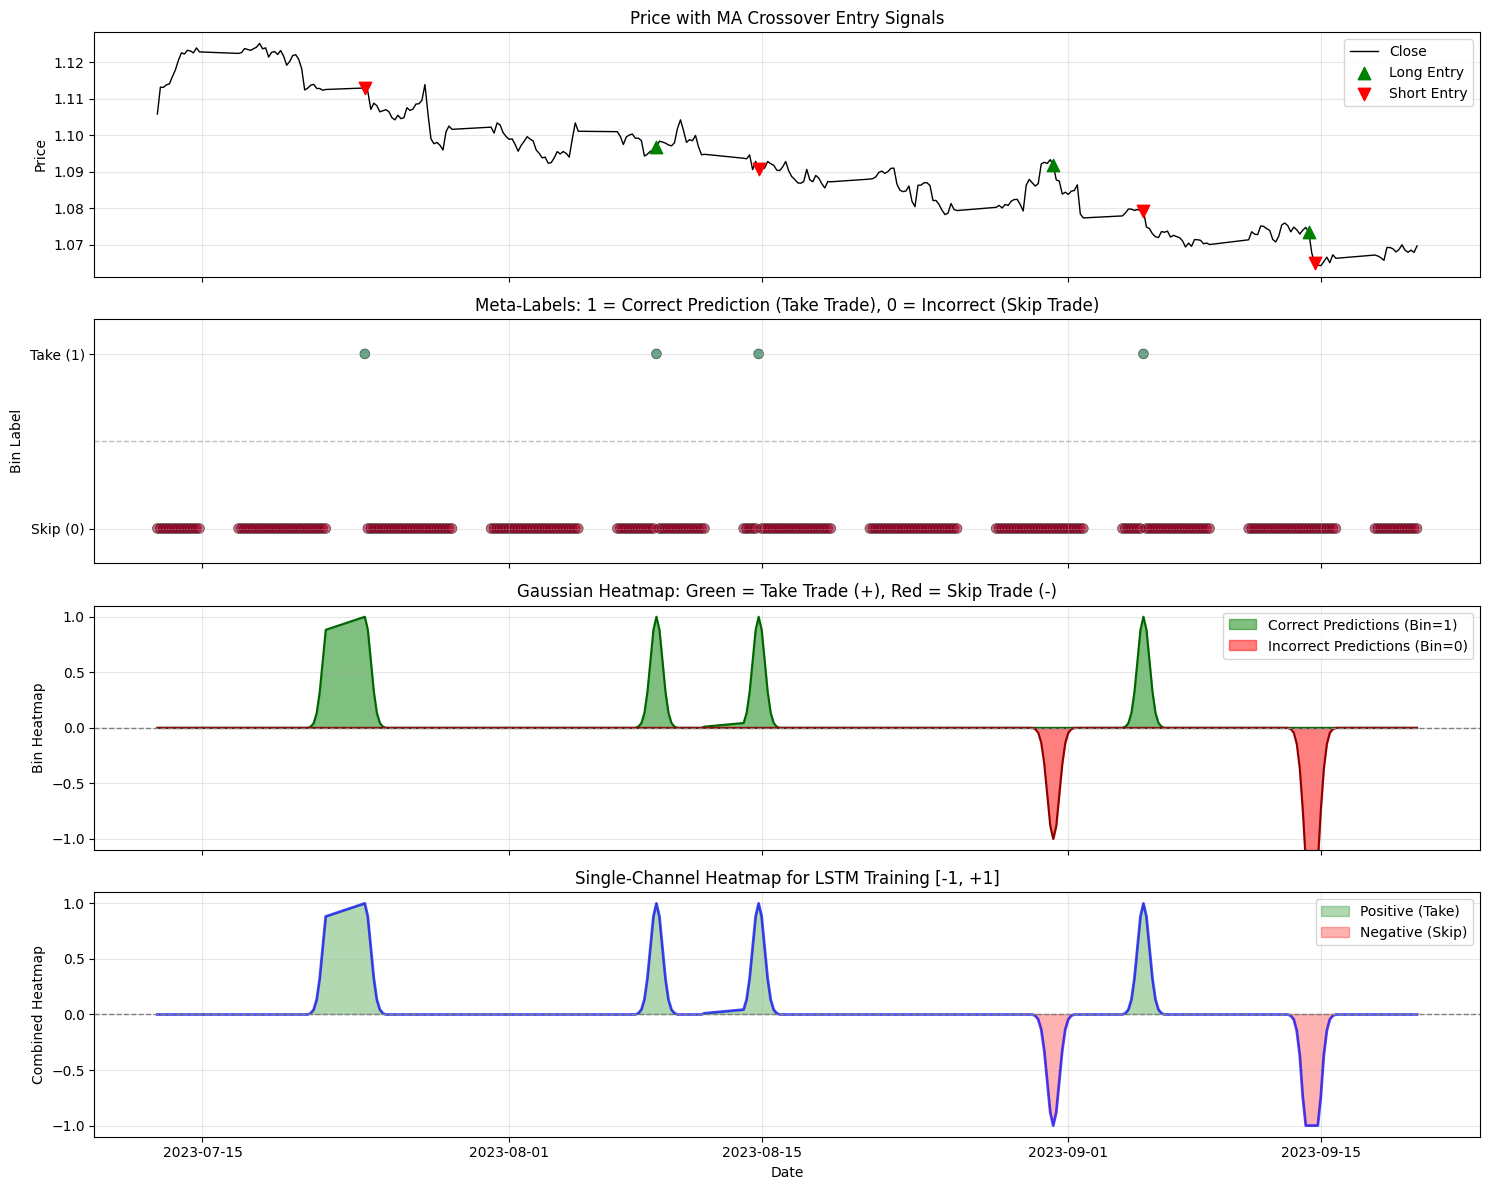


✅ BIN-BASED HEATMAP:
Meta-Labeling Approach:
  - Bin = 1 (Correct prediction) → Positive heatmap peak
  - Bin = 0 (Incorrect prediction) → Negative heatmap peak

Model Training:
  - Target: bin_heatmap column [-1, +1]
  - Prediction > 0 → Take the trade
  - Prediction < 0 → Skip the trade


In [24]:
# Visualize bin-based heatmap
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

plot_data = eurusd.iloc[-300:]

# Plot 1: Price with entry signals
axes[0].plot(plot_data.index, plot_data['close'], label='Close', color='black', linewidth=1)
long_entries = plot_data[plot_data['entry_signal'] == 1]
short_entries = plot_data[plot_data['entry_signal'] == -1]
axes[0].scatter(long_entries.index, long_entries['close'], color='green', marker='^', s=80, label='Long Entry', zorder=5)
axes[0].scatter(short_entries.index, short_entries['close'], color='red', marker='v', s=80, label='Short Entry', zorder=5)
axes[0].set_ylabel('Price')
axes[0].set_title('Price with MA Crossover Entry Signals', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Bin labels (0 or 1)
axes[1].scatter(plot_data.index, plot_data['bin_label'], c=plot_data['bin_label'], 
                cmap='RdYlGn', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_ylabel('Bin Label')
axes[1].set_title('Meta-Labels: 1 = Correct Prediction (Take Trade), 0 = Incorrect (Skip Trade)', fontsize=12)
axes[1].set_ylim([-0.2, 1.2])
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Skip (0)', 'Take (1)'])
axes[1].grid(alpha=0.3)

# Plot 3: Bin Heatmap - Positive and Negative separately
axes[2].fill_between(plot_data.index, 0, plot_data['positive_heatmap'], 
                      color='green', alpha=0.5, label='Correct Predictions (Bin=1)')
axes[2].fill_between(plot_data.index, 0, plot_data['negative_heatmap'], 
                      color='red', alpha=0.5, label='Incorrect Predictions (Bin=0)')
axes[2].plot(plot_data.index, plot_data['positive_heatmap'], color='darkgreen', linewidth=1.5)
axes[2].plot(plot_data.index, plot_data['negative_heatmap'], color='darkred', linewidth=1.5)
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1)
axes[2].set_ylabel('Bin Heatmap')
axes[2].set_title('Gaussian Heatmap: Green = Take Trade (+), Red = Skip Trade (-)', fontsize=12)
axes[2].set_ylim([-1.1, 1.1])
axes[2].legend()
axes[2].grid(alpha=0.3)

# Plot 4: Combined heatmap (single channel for model)
axes[3].plot(plot_data.index, plot_data['bin_heatmap'], color='blue', linewidth=2, alpha=0.7)
axes[3].fill_between(plot_data.index, 0, plot_data['bin_heatmap'], 
                      where=(plot_data['bin_heatmap'] > 0), 
                      color='green', alpha=0.3, label='Positive (Take)')
axes[3].fill_between(plot_data.index, 0, plot_data['bin_heatmap'], 
                      where=(plot_data['bin_heatmap'] < 0), 
                      color='red', alpha=0.3, label='Negative (Skip)')
axes[3].axhline(y=0, color='gray', linestyle='--', linewidth=1)
axes[3].set_ylabel('Combined Heatmap')
axes[3].set_xlabel('Date')
axes[3].set_title('Single-Channel Heatmap for LSTM Training [-1, +1]', fontsize=12)
axes[3].set_ylim([-1.1, 1.1])
axes[3].legend()
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✅ BIN-BASED HEATMAP:")
print("="*70)
print("Meta-Labeling Approach:")
print("  - Bin = 1 (Correct prediction) → Positive heatmap peak")
print("  - Bin = 0 (Incorrect prediction) → Negative heatmap peak")
print("\nModel Training:")
print("  - Target: bin_heatmap column [-1, +1]")
print("  - Prediction > 0 → Take the trade")
print("  - Prediction < 0 → Skip the trade")
print("="*70)


## Feature Engineering

Use same features as Phase 1-5 for consistency

In [25]:
def create_features(df):
    """Create same features as Phase 1-5"""
    df = df.copy()
    
    # Returns
    df['log_return_1'] = np.log(df['close'] / df['close'].shift(1))
    df['log_return_5'] = np.log(df['close'] / df['close'].shift(5))
    df['log_return_20'] = np.log(df['close'] / df['close'].shift(20))
    
    # Volatility
    df['volatility_20'] = df['log_return_1'].rolling(20).std()
    df['volatility_50'] = df['log_return_1'].rolling(50).std()
    
    # Range features
    df['high_low_range'] = df['high'] - df['low']
    df['close_open_diff'] = df['close'] - df['open']
    
    # Volume (if available)
    if 'tick_volume' in df.columns:
        df['volume_sma_20'] = df['tick_volume'].rolling(20).mean()
        df['volume_ratio'] = df['tick_volume'] / df['volume_sma_20']
    
    # Price momentum
    df['momentum_5'] = df['close'] - df['close'].shift(5)
    df['momentum_10'] = df['close'] - df['close'].shift(10)
    df['momentum_20'] = df['close'] - df['close'].shift(20)
    
    # We already have MA signals, add more MA-based features
    df['ma_distance'] = (df['close'] - df['ma_slow']) / df['ma_slow']
    df['ma_spread'] = (df['ma_fast'] - df['ma_slow']) / df['ma_slow']
    
    return df

eurusd = create_features(eurusd)

# Select feature columns (excluding target and intermediate columns)
FEATURE_COLS = [
    'log_return_1', 'log_return_5', 'log_return_20',
    'volatility_20', 'volatility_50',
    'high_low_range', 'close_open_diff',
    'momentum_5', 'momentum_10', 'momentum_20',
    'ma_distance', 'ma_spread'
]

# Add volume features if they exist
if 'volume_ratio' in eurusd.columns:
    FEATURE_COLS.append('volume_ratio')

print(f"Total features: {len(FEATURE_COLS)}")
print(f"Features: {FEATURE_COLS}")

# Check for NaN
print(f"\nNaN counts after feature engineering:")
print(eurusd[FEATURE_COLS].isna().sum())

# Drop NaN rows
eurusd_clean = eurusd.dropna()
print(f"\nData shape after dropping NaN: {eurusd_clean.shape}")
eurusd_clean.tail()

Total features: 13
Features: ['log_return_1', 'log_return_5', 'log_return_20', 'volatility_20', 'volatility_50', 'high_low_range', 'close_open_diff', 'momentum_5', 'momentum_10', 'momentum_20', 'ma_distance', 'ma_spread', 'volume_ratio']

NaN counts after feature engineering:
log_return_1        1
log_return_5        5
log_return_20      20
volatility_20      20
volatility_50      50
high_low_range      0
close_open_diff     0
momentum_5          5
momentum_10        10
momentum_20        20
ma_distance        49
ma_spread          49
volume_ratio       19
dtype: int64

Data shape after dropping NaN: (13626, 32)


,open,high,low,close,tick_volume,low_time,high_time,ma_fast,ma_slow,signal,signal_shift,entry_long,entry_short,entry_signal,bin_heatmap,bin_label,positive_heatmap,negative_heatmap,log_return_1,log_return_5,log_return_20,volatility_20,volatility_50,high_low_range,close_open_diff,volume_sma_20,volume_ratio,momentum_5,momentum_10,momentum_20,ma_distance,ma_spread
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-09-19 16:00:00,1.06997,1.07014,1.06785,1.06848,13607,2023-09-19 19:36:00,2023-09-19 16:00:00,1.067004,1.070427,-1,-1.0,0,0,0,0.0,0.0,0.0,-0.0,-0.001384,-0.000683,-0.004594,0.001793,0.001478,0.00229,-0.00149,10196.10,1.334530,-0.00073,0.00133,-0.00492,-0.001819,-0.003198
2023-09-19 20:00:00,1.06848,1.06918,1.06761,1.06790,6544,2023-09-19 22:00:00,2023-09-19 20:24:00,1.067015,1.070398,-1,-1.0,0,0,0,0.0,0.0,0.0,-0.0,-0.000543,-0.000889,0.000206,0.001336,0.001464,0.00157,-0.00058,9586.80,0.682605,-0.00095,0.00103,0.00022,-0.002334,-0.003161
2023-09-20 00:00:00,1.06790,1.06860,1.06768,1.06849,2478,2023-09-20 00:00:00,2023-09-20 03:36:00,1.067197,1.070360,-1,-1.0,0,0,0,0.0,0.0,0.0,-0.0,0.000552,0.000459,0.003412,0.001183,0.001459,0.00092,0.00059,8571.40,0.289101,0.00049,0.00209,0.00364,-0.001747,-0.002955
2023-09-20 04:00:00,1.06849,1.06897,1.06783,1.06786,4333,2023-09-20 06:24:00,2023-09-20 05:12:00,1.067370,1.070326,-1,-1.0,0,0,0,0.0,0.0,0.0,-0.0,-0.000590,-0.000758,0.003245,0.001188,0.001457,0.00114,-0.00063,8394.10,0.516196,-0.00081,0.00217,0.00346,-0.002304,-0.002762
2023-09-20 08:00:00,1.06786,1.06972,1.06730,1.06964,11014,2023-09-20 08:48:00,2023-09-20 11:36:00,1.067640,1.070291,-1,-1.0,0,0,0,0.0,0.0,0.0,-0.0,0.001665,-0.000299,0.005071,0.001231,0.001455,0.00242,0.00178,8750.55,1.258664,-0.00032,0.00042,0.00541,-0.000608,-0.002476


## Create Sliding Windows

In [32]:
def create_sliding_windows(df, feature_cols, target_col, window_size=60):
    """Create sliding windows for LSTM input"""
    X_list = []
    y_list = []
    
    for i in range(len(df) - window_size):
        # Window of features
        X_window = df[feature_cols].iloc[i:i+window_size].values
        
        # Target at next timestep (bin heatmap)
        y_target = df[target_col].iloc[i+window_size]
        
        X_list.append(X_window)
        y_list.append(y_target)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    return X, y

WINDOW_SIZE = 60
TARGET_COL = 'bin_heatmap'  # Use bin-based heatmap as target

print(f"Creating sliding windows (window_size={WINDOW_SIZE})...")
X, y = create_sliding_windows(eurusd_clean, FEATURE_COLS, TARGET_COL, window_size=WINDOW_SIZE)

print(f"\nWindow creation complete:")
print(f"  X shape: {X.shape} (samples, timesteps, features)")
print(f"  y shape: {y.shape}")
print(f"  y range: [{y.min():.4f}, {y.max():.4f}]")
print(f"  y mean: {y.mean():.4f}, std: {y.std():.4f}")
print(f"\nTarget distribution:")
print(f"  Positive values (bin=1): {(y > 0).sum()} ({(y > 0).sum() / len(y) * 100:.1f}%)")
print(f"  Negative values (bin=0): {(y < 0).sum()} ({(y < 0).sum() / len(y) * 100:.1f}%)")
print(f"  Zero values (no signal): {(y == 0).sum()} ({(y == 0).sum() / len(y) * 100:.1f}%)")


Creating sliding windows (window_size=60)...

Window creation complete:
  X shape: (13566, 60, 13) (samples, timesteps, features)
  y shape: (13566,)
  y range: [-1.0000, 1.0000]
  y mean: -0.0020, std: 0.2830

Target distribution:
  Positive values (bin=1): 1939 (14.3%)
  Negative values (bin=0): 1948 (14.4%)
  Zero values (no signal): 9679 (71.3%)

Window creation complete:
  X shape: (13566, 60, 13) (samples, timesteps, features)
  y shape: (13566,)
  y range: [-1.0000, 1.0000]
  y mean: -0.0020, std: 0.2830

Target distribution:
  Positive values (bin=1): 1939 (14.3%)
  Negative values (bin=0): 1948 (14.4%)
  Zero values (no signal): 9679 (71.3%)


## Train/Val/Test Split & Scaling

In [33]:
# Time-series split: 70% train, 15% val, 15% test
n = len(X)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train = X[:train_end]
y_train = y[:train_end]
X_val = X[train_end:val_end]
y_val = y[train_end:val_end]
X_test = X[val_end:]
y_test = y[val_end:]

print(f"Split sizes:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val: {len(X_val)} samples")
print(f"  Test: {len(X_test)} samples")

# Scale features to [-1, 1] range using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

n_samples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)

# MinMaxScaler with feature_range=(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train_reshaped)

def scale_data(X):
    n_s, n_t, n_f = X.shape
    X_reshaped = X.reshape(-1, n_f)
    X_scaled = scaler.transform(X_reshaped)
    return X_scaled.reshape(n_s, n_t, n_f)

X_train_scaled = scale_data(X_train)
X_val_scaled = scale_data(X_val)
X_test_scaled = scale_data(X_test)

print(f"\nScaling complete (MinMaxScaler [-1, 1]):")
print(f"  Train range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")
print(f"  Val range: [{X_val_scaled.min():.2f}, {X_val_scaled.max():.2f}]")
print(f"  Test range: [{X_test_scaled.min():.2f}, {X_test_scaled.max():.2f}]")

Split sizes:
  Train: 9496 samples
  Val: 2035 samples
  Test: 2035 samples

Scaling complete (MinMaxScaler [-1, 1]):
  Train range: [-1.00, 1.00]
  Val range: [-0.99, 0.65]
  Test range: [-1.00, 1.05]


## Build Simple Double-Layer LSTM Model

## Custom Loss Function: ConsistentPeakLoss

Adapted from Phase 4 - ensures model confidence on strong signals (bin=1 regions)

In [34]:
import tensorflow as tf

class ConsistentPeakLoss(tf.keras.losses.Loss):
    """
    Custom loss for meta-labeling heatmaps.
    
    Ensures model is confident when heatmap signals are strong:
    - Strong positive signal (y_true > threshold): prediction should be high positive
    - Strong negative signal (y_true < -threshold): prediction should be high negative
    - Weak signal (|y_true| < threshold): allow flexibility
    
    This encourages the model to:
    1. Be confident (+0.7 or higher) when bin=1 (take trade)
    2. Be confident (-0.7 or lower) when bin=0 (skip trade)
    3. Be uncertain (near 0) when no clear signal
    
    Args:
        target_height: Target confidence level (e.g., 0.7 for strong signals)
        peak_threshold: Threshold for "strong signal" (e.g., 0.3)
        peak_weight: Weight for peak consistency penalty
        base_loss: Base regression loss ('mse' or 'huber')
    """
    def __init__(self, 
                 target_height=0.7,
                 peak_threshold=0.3,
                 peak_weight=0.3,
                 base_loss='mse',
                 name="consistent_peak_loss"):
        super().__init__(name=name)
        self.target_height = target_height
        self.peak_threshold = peak_threshold
        self.peak_weight = peak_weight
        self.base_loss = base_loss
    
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Ensure shape compatibility
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        
        # === Base regression loss ===
        if self.base_loss == 'mse':
            base_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        elif self.base_loss == 'huber':
            delta = 1.0
            abs_error = tf.abs(y_true - y_pred)
            quadratic = tf.minimum(abs_error, delta)
            linear = abs_error - quadratic
            base_loss = tf.reduce_mean(0.5 * tf.square(quadratic) + delta * linear)
        else:
            base_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # === Peak Consistency Penalty ===
        # Identify strong signals (high magnitude in heatmap)
        strong_signal_mask = tf.cast(tf.abs(y_true) > self.peak_threshold, tf.float32)
        
        # For positive strong signals: target is +target_height
        # For negative strong signals: target is -target_height
        target_values = tf.sign(y_true) * self.target_height * strong_signal_mask
        
        # Identify weak predictions in strong signal regions
        # The prediction should match the sign AND have magnitude >= target_height
        signed_pred_magnitude = y_pred * tf.sign(y_true)  # Align with true signal direction
        weak_prediction_mask = tf.cast(signed_pred_magnitude < self.target_height, tf.float32)
        
        # Combined penalty mask: strong signal AND weak prediction
        penalty_mask = strong_signal_mask * weak_prediction_mask
        
        # Calculate penalty (MSE between prediction and target, only in penalty regions)
        peak_mse = tf.square(y_pred - target_values) * penalty_mask
        
        # Average penalty (avoid division by zero)
        num_penalty_points = tf.reduce_sum(penalty_mask)
        peak_loss = tf.cond(
            tf.greater(num_penalty_points, 0),
            lambda: tf.reduce_sum(peak_mse) / num_penalty_points,
            lambda: 0.0
        )
        
        # Combined loss
        total_loss = base_loss + self.peak_weight * peak_loss
        
        return total_loss
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'target_height': self.target_height,
            'peak_threshold': self.peak_threshold,
            'peak_weight': self.peak_weight,
            'base_loss': self.base_loss
        })
        return config

print("ConsistentPeakLoss defined successfully!")
print("\nLoss configuration:")
print(f"  - Target height: 0.7 (predictions should reach ±0.7 for strong signals)")
print(f"  - Peak threshold: 0.3 (signals with |heatmap| > 0.3 are 'strong')")
print(f"  - Peak weight: 0.3 (30% weight on confidence penalty)")
print(f"  - Base loss: MSE")

ConsistentPeakLoss defined successfully!

Loss configuration:
  - Target height: 0.7 (predictions should reach ±0.7 for strong signals)
  - Peak threshold: 0.3 (signals with |heatmap| > 0.3 are 'strong')
  - Peak weight: 0.3 (30% weight on confidence penalty)
  - Base loss: MSE


In [45]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.optimizers import Adam

print(f"TensorFlow version: {tf.__version__}")

def create_simple_lstm_model(input_shape, lstm_units=[64, 32], dropout=0.2):
    """
    Simple double-layer LSTM for heatmap regression
    
    Args:
        input_shape: (timesteps, features)
        lstm_units: List of units for each LSTM layer
        dropout: Dropout rate
    """
    inputs = layers.Input(shape=input_shape, name='input')
    
    # First LSTM layer (return sequences for stacking)
    x = layers.LSTM(
        lstm_units[0],
        return_sequences=True,
        dropout=dropout,
        recurrent_dropout=dropout * 0.5,
        name='lstm_1'
    )(inputs)
    
    # Second LSTM layer
    x = layers.LSTM(
        lstm_units[1],
        return_sequences=False,
        dropout=dropout,
        recurrent_dropout=dropout * 0.5,
        name='lstm_2'
    )(x)
    
    # Output layer (tanh for [-1, +1] range)
    outputs = layers.Dense(1, activation='tanh', name='output')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='simple_lstm')
    return model

# Create model
model = create_simple_lstm_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    lstm_units=[32, 16],
    dropout=0.4
)

# Compile with ConsistentPeakLoss
consistent_peak_loss = ConsistentPeakLoss(
    target_height=0.3,    # Predictions should reach ±0.7 for strong signals
    peak_threshold=0.3,   # Signals with |heatmap| > 0.3 are considered strong
    peak_weight=0.3,      # 30% weight on confidence penalty
    base_loss='mse'
)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss=consistent_peak_loss,
    metrics=['accuracy']
)

model.summary()

print("\n" + "="*70)
print("Model compiled with ConsistentPeakLoss!")
print("="*70)
print("This loss will encourage:")
print("  ✓ High confidence (±0.7) when bin=1 regions (good trades)")
print("  ✓ Low confidence (near 0) when uncertain")
print("  ✓ Better separation between take/skip trade predictions")
print("="*70)

TensorFlow version: 2.20.0


Model: "simple_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 60, 13)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 32)         │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,041 (35.32 KB)

 Trainable params: 9,041 (35.32 KB)

 Non-trainable params: 0 (0.00 B)


Model compiled with ConsistentPeakLoss!
This loss will encourage:
  ✓ High confidence (±0.7) when bin=1 regions (good trades)
  ✓ Low confidence (near 0) when uncertain
  ✓ Better separation between take/skip trade predictions


## Train Model

In [46]:
# Setup callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Train
print("Starting training...\n")
history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=1
)

print("\nTraining complete!")
print(f"  Best val_loss: {min(history.history['val_loss']):.4f}")
print(f"  Final train_loss: {history.history['loss'][-1]:.4f}")
print(f"  Final val_loss: {history.history['val_loss'][-1]:.4f}")
print(f"  Overfitting gap: {history.history['val_loss'][-1] - history.history['loss'][-1]:.4f}")

Starting training...

Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.7075 - loss: 0.1637 - val_accuracy: 0.7243 - val_loss: 0.1034 - learning_rate: 1.0000e-05
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.7075 - loss: 0.1637 - val_accuracy: 0.7243 - val_loss: 0.1034 - learning_rate: 1.0000e-05
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7140 - loss: 0.1421 - val_accuracy: 0.7243 - val_loss: 0.0987 - learning_rate: 1.0000e-05
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7140 - loss: 0.1421 - val_accuracy: 0.7243 - val_loss: 0.0987 - learning_rate: 1.0000e-05
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7146 - loss: 0.1367 - val_accuracy: 0.7243 - val_loss: 0.0974 - learning_rate: 1.0000e-05
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7146 - loss: 0.1367 - val_accuracy: 0.7243 - val_loss: 0.0974 - learning_rate: 1.0000e-05
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━

KeyError: 'regression_output_loss'

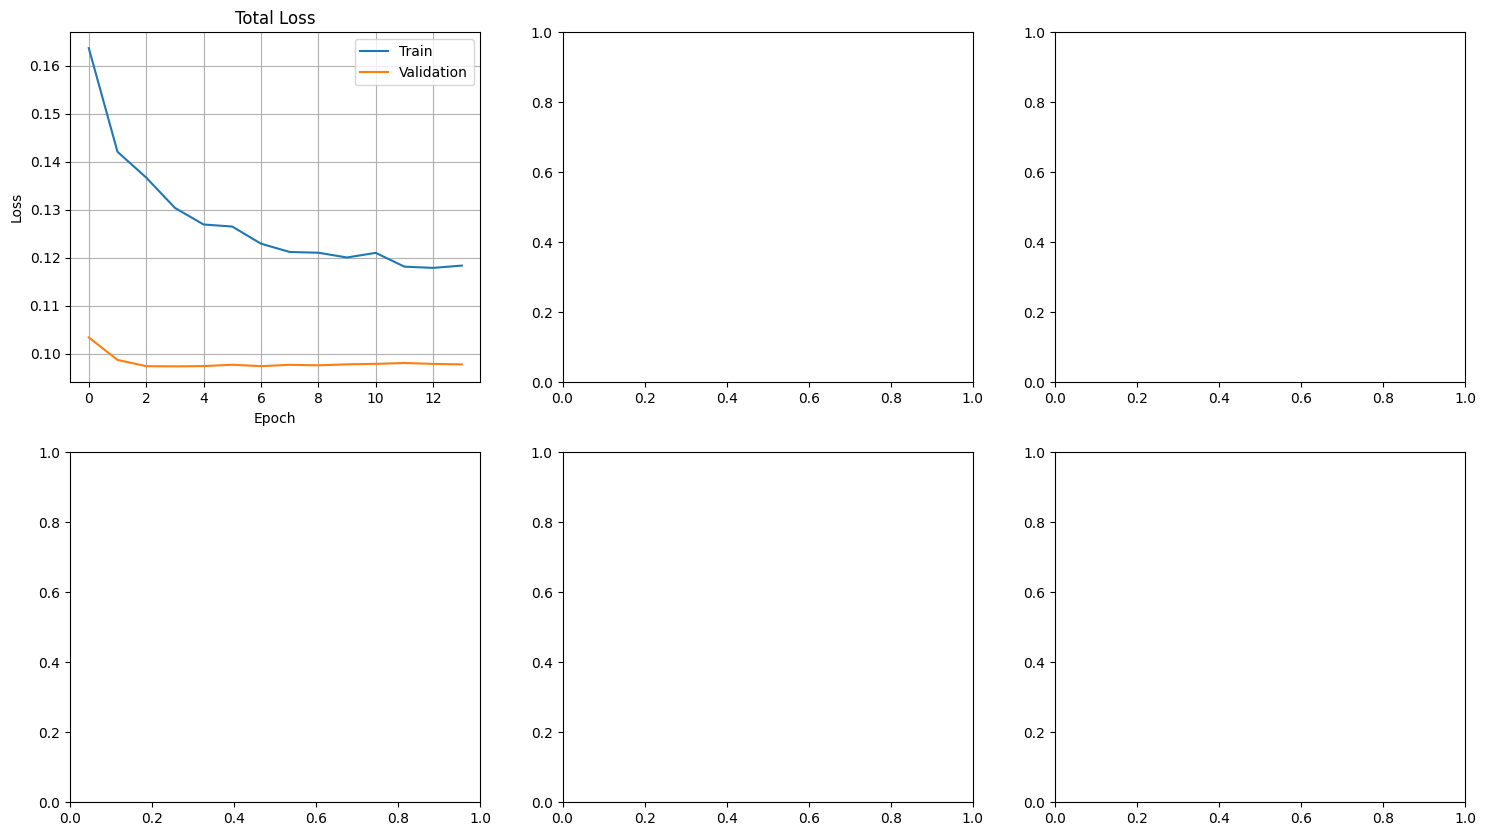

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Total loss
axes[0, 0].plot(history.history['loss'], label='Train')
axes[0, 0].plot(history.history['val_loss'], label='Validation')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)


# Regression loss
axes[0, 2].plot(history.history['regression_output_loss'], label='Train')
axes[0, 2].plot(history.history['val_regression_output_loss'], label='Validation')
axes[0, 2].set_title('Regression Loss (MSE)')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True)



# Regression MAE
axes[1, 2].plot(history.history['regression_output_mae'], label='Train')
axes[1, 2].plot(history.history['val_regression_output_mae'], label='Validation')
axes[1, 2].set_title('Regression MAE')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('MAE')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training history plot saved to {MODEL_DIR / 'training_history.png'}")

## Evaluate Results

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Get predictions
y_pred_train = model.predict(X_train_scaled, verbose=0).flatten()
y_pred_val = model.predict(X_val_scaled, verbose=0).flatten()
y_pred_test = model.predict(X_test_scaled, verbose=0).flatten()

# Calculate metrics
def calculate_metrics(y_true, y_pred, set_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Direction accuracy
    dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    
    # Strong signal analysis (|y_true| > 0.3)
    strong_mask = np.abs(y_true) > 0.3
    if strong_mask.sum() > 0:
        strong_dir_acc = np.mean(np.sign(y_true[strong_mask]) == np.sign(y_pred[strong_mask]))
        strong_mae = mean_absolute_error(y_true[strong_mask], y_pred[strong_mask])
    else:
        strong_dir_acc = None
        strong_mae = None
    
    print(f"\n{set_name} Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  Direction Accuracy: {dir_acc:.2%}")
    if strong_dir_acc is not None:
        print(f"  Strong Signal Direction Acc: {strong_dir_acc:.2%} ({strong_mask.sum()} samples)")
        print(f"  Strong Signal MAE: {strong_mae:.4f}")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'direction_accuracy': dir_acc,
        'strong_direction_accuracy': strong_dir_acc,
        'strong_mae': strong_mae,
        'strong_count': int(strong_mask.sum())
    }

train_metrics = calculate_metrics(y_train, y_pred_train, "TRAIN")
val_metrics = calculate_metrics(y_val, y_pred_val, "VALIDATION")
test_metrics = calculate_metrics(y_test, y_pred_test, "TEST")

print("\n" + "="*70)
print("SUMMARY:")
print("="*70)
print(f"Overfitting gap: {val_metrics['mae'] - train_metrics['mae']:.4f}")
print(f"Test strong signal direction: {test_metrics['strong_direction_accuracy']:.2%}")


TRAIN Metrics:
  MAE: 0.1390
  RMSE: 0.2837
  R²: -0.0228
  Direction Accuracy: 15.35%
  Strong Signal Direction Acc: 53.21% (1481 samples)
  Strong Signal MAE: 0.6577

VALIDATION Metrics:
  MAE: 0.1339
  RMSE: 0.2846
  R²: -0.0187
  Direction Accuracy: 12.43%
  Strong Signal Direction Acc: 44.12% (306 samples)
  Strong Signal MAE: 0.6766

TEST Metrics:
  MAE: 0.1603
  RMSE: 0.3041
  R²: -0.0823
  Direction Accuracy: 11.84%
  Strong Signal Direction Acc: 37.43% (342 samples)
  Strong Signal MAE: 0.6794

SUMMARY:
Overfitting gap: -0.0051
Test strong signal direction: 37.43%


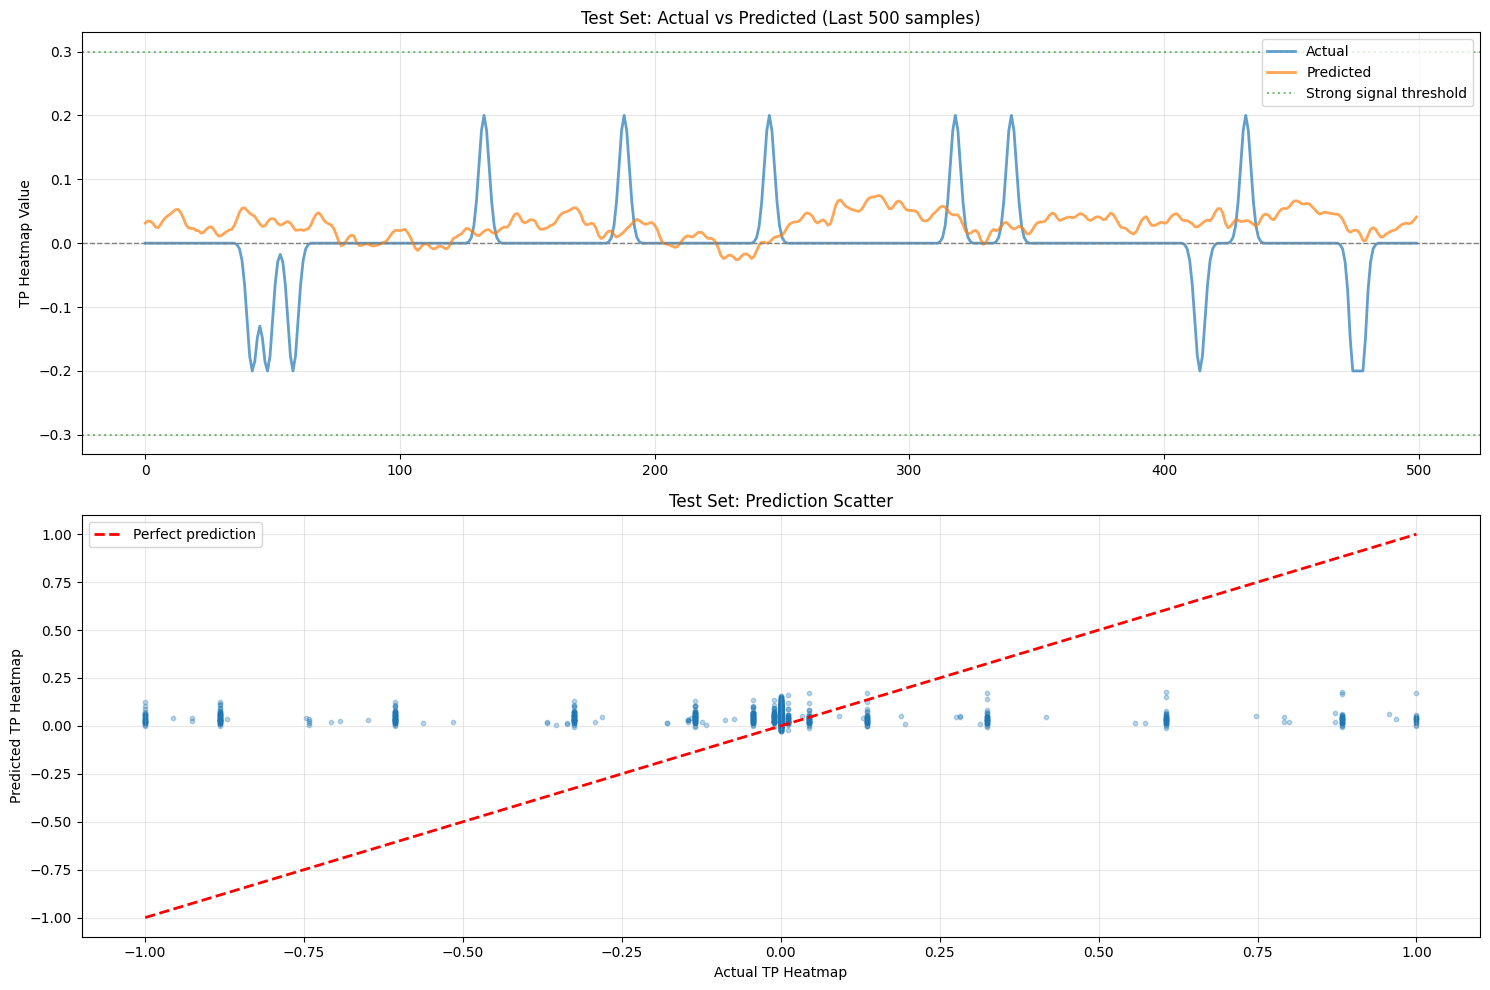

In [52]:
# Plot predictions vs actual
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Test set predictions
sample_size = 500
test_sample = slice(-sample_size, None)

axes[0].plot(y_test[test_sample]/5, label='Actual', alpha=0.7, linewidth=2)
axes[0].plot(y_pred_test[test_sample], label='Predicted', alpha=0.7, linewidth=2)
axes[0].axhline(y=0, color='gray', linestyle='--', linewidth=1)
axes[0].axhline(y=0.3, color='green', linestyle=':', alpha=0.5, label='Strong signal threshold')
axes[0].axhline(y=-0.3, color='green', linestyle=':', alpha=0.5)
axes[0].set_ylabel('TP Heatmap Value')
axes[0].set_title(f'Test Set: Actual vs Predicted (Last {sample_size} samples)', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Scatter plot
axes[1].scatter(y_test, y_pred_test, alpha=0.3, s=10)
axes[1].plot([-1, 1], [-1, 1], 'r--', linewidth=2, label='Perfect prediction')
axes[1].set_xlabel('Actual TP Heatmap')
axes[1].set_ylabel('Predicted TP Heatmap')
axes[1].set_title('Test Set: Prediction Scatter', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_xlim([-1.1, 1.1])
axes[1].set_ylim([-1.1, 1.1])

plt.tight_layout()
plt.show()